In [336]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

from os.path import expanduser

data_dir = "C:\\users\\oreog\\lab\\braindump\\data" # os.path.dirname(os.path.realpath(__file__)) + "\\data"
df_wordprompt_data = pd.read_csv( data_dir + "\\session001-wordprompts.csv")
df_eeg_data = pd.read_csv( data_dir + "\\session001 - Notion-255.data.csv")
df_keystroke_data = pd.read_csv( data_dir + "\\session001 - Curia IO - Buttons.data.csv")

# get the required columns
df_eeg_data = df_eeg_data.iloc[:, 0:9]
df_eeg_data

,lsl_time_stamp,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8
0,1.613434e+12,-49122.250000,-47196.089844,-94880.000000,3867.142334,-51044.656250,-7725.902832,-30040.408203,-45337.718750
1,1.613434e+12,-49146.925781,-47358.027344,-83741.726563,15081.928711,-51326.691406,-7438.839355,-22893.595703,-32746.556641
2,1.613434e+12,-49149.207031,-47302.570313,-82644.296875,16218.582031,-51132.097656,-7602.118652,-23056.673828,-28920.183594
3,1.613434e+12,-49127.480469,-47187.035156,-90344.718750,8461.766602,-50936.093750,-7780.284668,-27963.507813,-37376.722656
4,1.613434e+12,-49123.187500,-47177.781250,-95412.351563,3331.505127,-50995.640625,-7764.057129,-30488.136719,-45538.347656
...,...,...,...,...,...,...,...,...,...
73469,1.613434e+12,-48207.953125,-44107.257813,-99421.718750,-7291.988281,-53507.996094,-5303.398438,-33840.429688,-39774.480469
73470,1.613434e+12,-48197.691406,-44100.484375,-100850.468750,-8754.127930,-53508.800781,-5305.879395,-34261.804688,-42025.929688
73471,1.613434e+12,-48184.214844,-44111.347656,-97666.015625,-5542.651367,-53564.726563,-5217.232422,-32619.353516,-38481.925781
73472,1.613434e+12,-48192.195313,-44122.476563,-97580.851563,-5444.348633,-53536.292969,-5265.579102,-32879.058594,-37777.308594


In [337]:
df_keystroke_data

,lsl_time_stamp,Button Label,State,Unix Timestamp,Recording Timestamp (Unix Epoch)
0,91595.377866,Mouse Left,Down,1.613434e+09,1.613434e+12
1,91595.599855,Mouse Left,Up,1.613434e+09,1.613434e+12
2,91597.237901,Key S,Down,1.613434e+09,1.613434e+12
3,91597.362843,Key S,Up,1.613434e+09,1.613434e+12
4,91597.588932,Key E,Down,1.613434e+09,1.613434e+12
...,...,...,...,...,...
732,91881.893372,Key AltL,Down,1.613434e+09,1.613434e+12
733,91882.274991,Key AltL,Up,1.613434e+09,1.613434e+12
734,91884.451929,Mouse Left,Down,1.613434e+09,1.613434e+12
735,91884.677880,Mouse Left,Up,1.613434e+09,1.613434e+12


In [338]:
"""get the timestamp dataframes for a given word prompt
TODO: This should be changed to do for an array of word prompts
"""

# create an encorder for all the buttons
button_label_enc = preprocessing.LabelEncoder()
button_label_enc.fit( df_keystroke_data['Button Label'] )

# Encode the button label in dataframe
df_keystroke_data['Button_Label_Enc'] = button_label_enc.transform(df_keystroke_data['Button Label'] )

# define the search pattern - wordprompt = easy
""" Take a given word and then get the keystroke pattern for it"""
def get_wordkeystroke_pattern(word):
    keystroke_list = [] # this shoudl simulate a down press and up press for a given key
    for letter in word:
        uppercase_letter = letter.upper()
        keystroke_list.append(f"Key {uppercase_letter}")
        keystroke_list.append(f"Key {uppercase_letter}")
    
    return keystroke_list

wordprompt = "easy"
wordprompts = ["python", "jumble", "easy", "difficult", "answer",  "xylophone"]
pattern = get_wordkeystroke_pattern(wordprompt)
print(pattern)
pattern_enc = list(button_label_enc.transform(pattern))
N = len(pattern)

# Find rows that match given word patterns
df_keystroke_data['wordpatternmatch'] = (df_keystroke_data['Button_Label_Enc'].rolling(window=N , min_periods=N)
                          .apply(lambda x: (x==pattern_enc).all())
                          .mask(lambda x: x == 0) 
                          .bfill(limit=N-1)
                          .fillna(0)
                          .astype(bool)
             )
df_keystroke_data['wordprompt'] = wordprompt

# this coontains cleaned data the matches a pattern
df_keystroke_data = df_keystroke_data[ df_keystroke_data['wordpatternmatch'] == True ]

# lsl_time_stamp in eeg data maps to "Unix Timestamp * 1000" to "keystroke"
df_keystroke_data['TIMESTAMP_ms'] = df_keystroke_data['Unix Timestamp'] * 1000
df_keystroke_data['TIMESTAMP_ms'] = df_keystroke_data['TIMESTAMP_ms'].astype('int64') 

df_eeg_data["lsl_time_stamp"] = df_eeg_data["lsl_time_stamp"].astype('int64')

df_eeg_data = df_eeg_data.rename(columns={'Channel 1': 'CP5', 'Channel 2': 'F5', 'Channel 3': 'C3', 'Channel 4': 'CP3', 
                                        'Channel 5': 'CP6', 'Channel 6': 'F6', 'Channel 7': 'C4', 'Channel 8': 'CP4'})


# use keystroke data to parse eeg data and get epochs for samples get wordprompt timestamp
# get start and end timestamp for given word press and then use that range to get the data from the eeg set
keystroke_entries = len(df_keystroke_data)
samples_per_word_prompt = len(pattern)
wordprompt_timestamps = []
for i in range(int(keystroke_entries/samples_per_word_prompt)):
    df_eeg_copy = df_eeg_data

    # add a step multiplier
    i = i*samples_per_word_prompt
    start_timestamp = df_keystroke_data.iloc[i]['TIMESTAMP_ms']
    end_timestamp = df_keystroke_data.iloc[i+(samples_per_word_prompt-1)]['TIMESTAMP_ms']

    # only get data for when the word was typed
    filter1 = df_eeg_copy["lsl_time_stamp"] >= start_timestamp
    filter2 = df_eeg_copy["lsl_time_stamp"] < end_timestamp
    df_eeg_prompt = df_eeg_copy.loc[filter1 & filter2]
    
    wordprompt_timestamps.append(df_eeg_prompt)


wordprompt_timestamps[0]

['Key E', 'Key E', 'Key A', 'Key A', 'Key S', 'Key S', 'Key Y', 'Key Y']


ipykernel_launcher:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,lsl_time_stamp,CP5,F5,C3,CP3,CP6,F6,C4,CP4
4672,1613433542906,-48842.964844,-47288.691406,-94197.382813,1279.346802,-51052.367188,-7223.458008,-29615.144531,-40583.437500
4673,1613433542910,-48843.433594,-47349.445313,-93820.593750,1637.891113,-51213.703125,-7102.557129,-28784.666016,-42125.773438
4674,1613433542914,-48850.742188,-47445.867188,-84932.757813,10602.639648,-51368.265625,-6915.406250,-23435.201172,-31351.205078
4675,1613433542918,-48849.066406,-47376.199219,-86304.242188,9243.764648,-51198.078125,-7061.787598,-24890.835938,-31015.996094
4676,1613433542922,-48824.187500,-47278.433594,-92987.234375,2505.585938,-51045.394531,-7201.262695,-28979.796875,-38767.714844
...,...,...,...,...,...,...,...,...,...
5070,1613433544502,-48829.218750,-47402.484375,-88274.257813,7037.581055,-51199.152344,-7014.916016,-25955.337891,-33702.496094
5071,1613433544506,-48817.347656,-47356.148438,-91653.039063,3623.933105,-51123.378906,-7090.822754,-28025.800781,-37620.132813
5072,1613433544510,-48817.082031,-47367.750000,-93152.187500,2095.006592,-51174.878906,-7057.630371,-28620.111328,-40497.406250
5073,1613433544514,-48830.960938,-47441.511719,-87859.117188,7434.950195,-51309.257813,-6935.254395,-25329.041016,-34518.691406


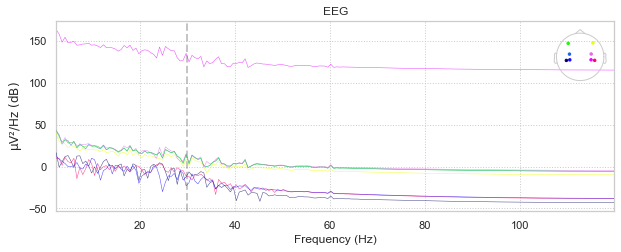

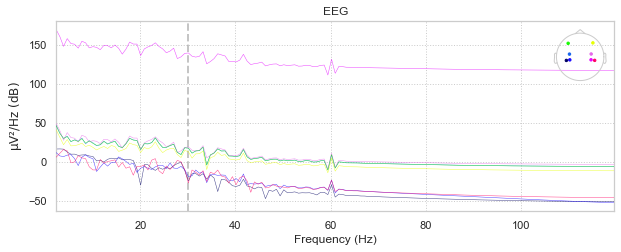

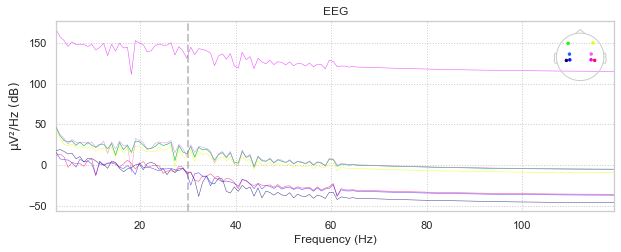

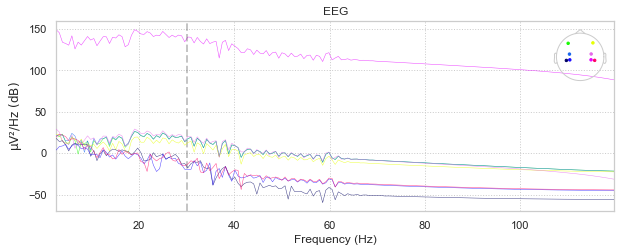

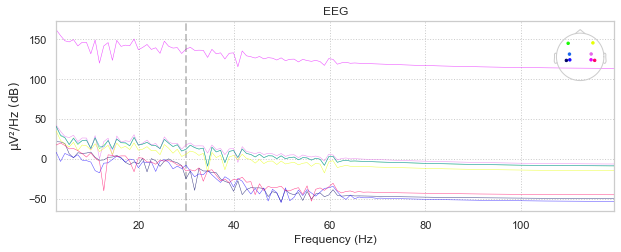

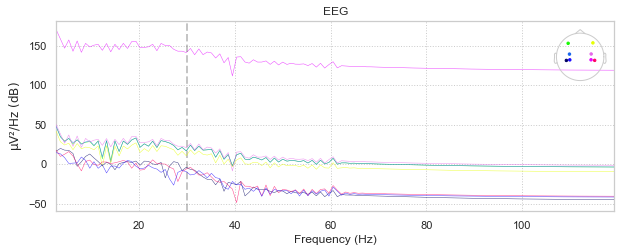

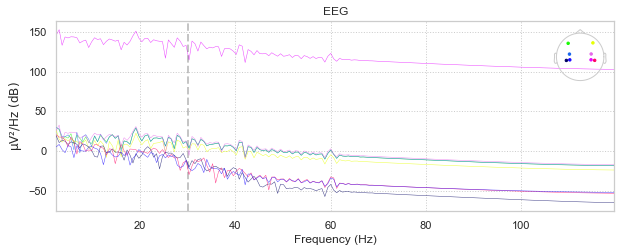

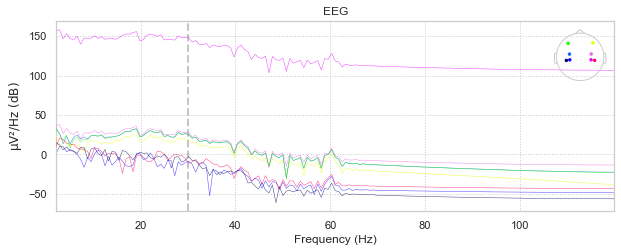

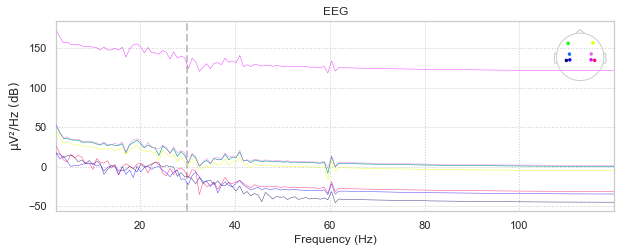

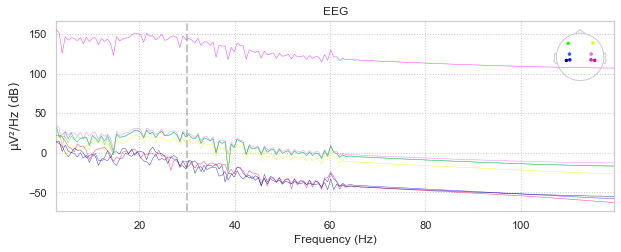

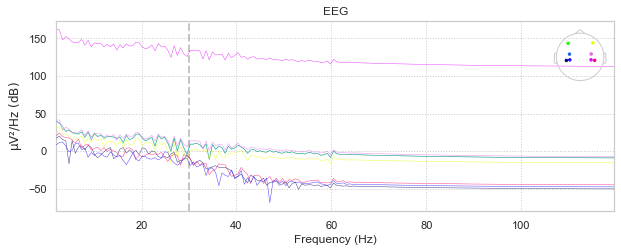

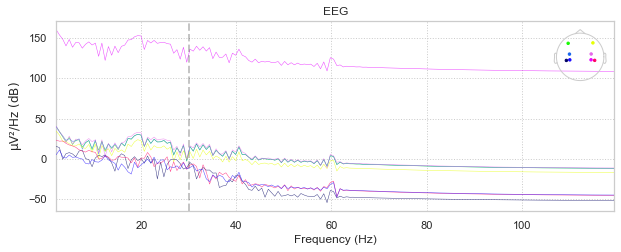

In [339]:
"""Extra preprocessing with mne
"""
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import make_standard_montage

ch_names = ['lsl_time_stamp', 'CP5', 'F5', 'C3', 'CP3',	'CP6', 'F6', 'C4', 'CP4']
ch_ind = [1,2,3,4,5,6,7,8]
ch_types = ['misc'] + ['eeg'] * len(ch_ind) # 8 notion channels
sfreq = 250 # sampling frequency 250Hz

preprocessed_wordprompt_eegs = []
for data in wordprompt_timestamps:

    # Transpose EEG data and convert from uV to Volts
    data = data.values[:, ch_ind + [-1]].T
    data[:-1] *= 1e-6

    # create MNE object
    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, verbose=1)
    raw = RawArray(data=data, info=info, verbose=False) 
    montage = make_standard_montage("standard_1005")
    raw.set_montage(montage)

    # filter out frequency for noise
    raw.filter(l_freq=2, h_freq=30, method="iir")
    # raw.notch_filter([57,58,59,60,61,62,63,64,65,66,67,68,69,70])
    # for validation 
    raw.plot_psd(fmin=2, fmax=120)

    filtered_wordprompt_df = raw.to_data_frame()

    preprocessed_wordprompt_eegs.append(filtered_wordprompt_df)


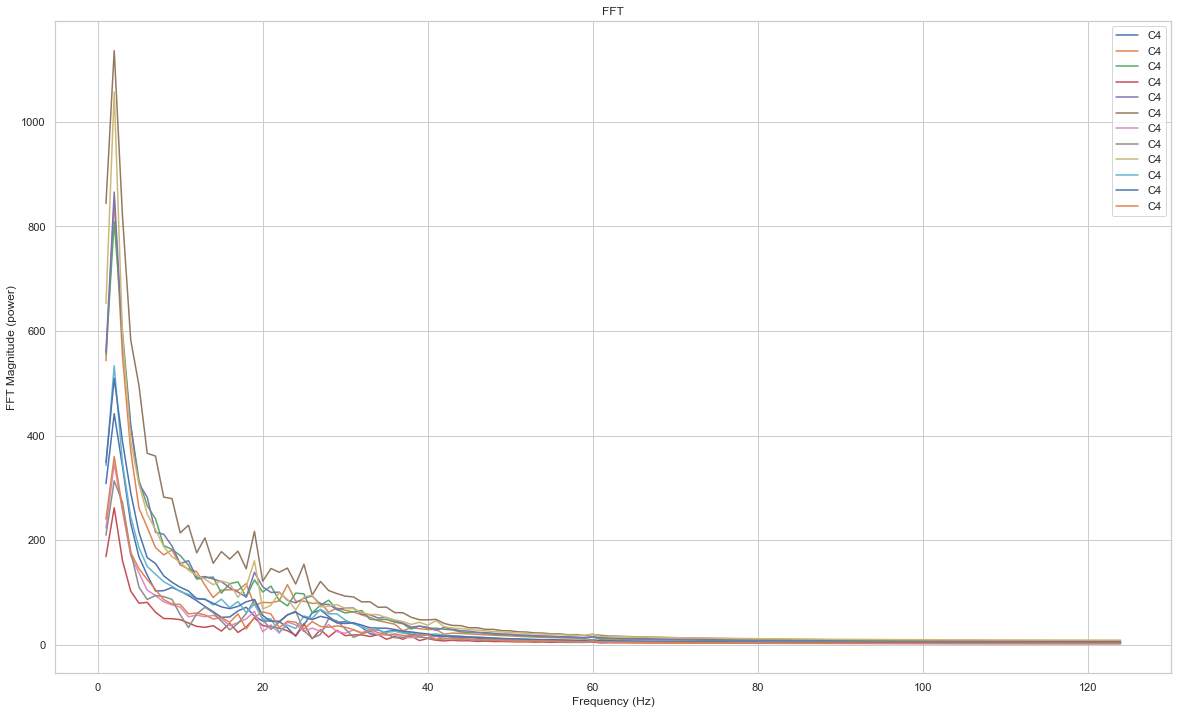

In [340]:
"""plot single channel as fft
"""

from numpy.fft import fft, fftfreq, ifft

data_rate   = 250 # samples per second
nfft        = 250 # number of samples to put in fourier (1sec of data)
fft_rescale = True


def get_fft_theo_and_freqs(y,data_rate,nfft,fft_rescale=False):
    
    fft_rescale_val = 1.0
    if fft_rescale:
        n_zeros = len(np.where(y==0)[0])
        fft_rescale_val = len(y) / (len(y) - n_zeros)

    
    sample_spacing = 1.0 / data_rate
    freqs          = fftfreq(nfft, d = sample_spacing)
    freq_mask      = freqs > 0
    
    # FFT and power spectra calculations
    n_samples       = len(y)
    fft_vals        = fft(y, n=nfft)
        
    fft_theo        = np.copy(fft_vals)
    fft_theo        = fft_rescale_val * 2.0 * np.abs( fft_vals / n_samples ) # true theoretical fft
    fft_theo[0]     = fft_theo[0] / 2.0
    
    return fft_theo[freq_mask], freqs[freq_mask]

sns.set_theme(style="whitegrid")
plt.figure(figsize = (20,12)) 

fft_power_data = [] # power data for a single word

for word_prompt_sample in preprocessed_wordprompt_eegs:

    # for channel in ['C4']: #['CP5', 'F5', 'C3', 'CP3', 'CP6', 'F6', 'C4']: # note that CP4 is being ignored 
    power, frequency = get_fft_theo_and_freqs( word_prompt_sample['C4'], data_rate, nfft, fft_rescale)
    fft_power_data.append(power)
    
    plt.plot(frequency, power, label=channel)
    plt.xlabel("Frequency (Hz)") 
    plt.ylabel("FFT Magnitude (power)") 
    plt.title("FFT") 
    plt.legend()


In [341]:
"""Collate data for different word prompts
"""

# split into training and testing set

'Collate data for different word prompts\n'

In [342]:
"""Trains a model based on eeg word prompt ffts
"""

# from gpt import set_openai_key, GPT, Example

# set_openai_key("")

# # Construct GPT object and show some examples
# gpt = GPT(engine="davinci",
#           temperature=0.5,
#           max_tokens=100)

# def convert_fft_to_string(fft_array, lfreq, hfreq):
#     fft_string = ""
#     for index in range(lfreq, hfreq):
#         if( index <= 2 or index > 50):
#             continue
        
#         fft_string += str(fft_array[index]) + ","
    
#     return fft_string.rstrip(",")

# print(len(fft_power_data))
# # create a new gpt example usingg the 
# for fft_easy_sample in fft_power_data:
#     fft_string = convert_fft_to_string(fft_easy_sample, 2, 51)

#     # - send fft prompt for channel to gpt "wordprompt: easy; fft: [rrrbs,bsbssbsbs]"
#     gpt.add_example(Example(f'fft: [{fft_string}]', f'wordprompt: {wordprompt}'))

# # view the examples that are sent

# # try to get top reply for a given fft array 
# # test_fft_string = "" #convert_fft_to_string(fft_power_data[])   #this is a sample fft string
# # print(gpt.get_top_reply(test_fft_string))
# gpt.get_all_examples()

'Trains a model based on eeg word prompt ffts\n'